(machine-learning-replication-protein-domains)=

# Machine learning algorithm based on protein domains

## Importing libraries and datasets

- Replication of results from paper: "Predicting yeast synthetic lethal genetic interactions using protein domains"
    - Authors: Bo Li, Feng Luo,School of Computing,Clemson University,Clemson, SC, USA
    - e-mail: bol, luofeng@clemson.edu
    - year:2009

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict 
import seaborn as sns
import matplotlib.cm as cm
import scipy as scipy
import random

### Download datasets from this github repo 👇

The link: https://github.com/leilaicruz/machine-learning-for-yeast/tree/dev_Leila/datasets-for-learning

In [2]:
## Datasets 
my_path_domains= r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\machine-learning-for-yeast\datasets-for-learning\proteins-domains-from-Pfam.xlsx'
my_path_sl= r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\machine-learning-for-yeast\datasets-for-learning\data-synthetic-lethals.xlsx'
my_path_non_sl= r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\machine-learning-for-yeast\datasets-for-learning\data-positive-genetic.xlsx'

data_domains=pd.read_excel(my_path_domains,header=0,index_col='Unnamed: 0')
data_domains=data_domains.dropna()
data_sl=pd.read_excel(my_path_sl,header=0)
data_nonsl=pd.read_excel(my_path_non_sl,header=0)

## Building the feature matrix
One matrix for true SL where each row is one pair of SL. Every raw will be a vector of 0,1 or 2 depending on the comparison with the domain list. For row i the jth element = 0 if the jth element of the domain list is not in neither protein A and B, 1, if it is in one of them and 2 if it is in both of them .

### Building the list of proteins domains id per protein pair separately :
List of protein A: Search for the Sl/nSL database the query gene name and look in the protein domain database which protein domains id has each of those queries.
List of protein B: Search for the Sl/nSL database the target gene name of the previous query and look in the protein domain database which protein domains id has each of those target genes.

In [3]:
# Selecting the meaningful columns in the respective dataset
domain_id_list=data_domains['domain-name']
query_gene=data_sl['gene-query-name']
target_gene=data_sl['gene-target-name']
query_gene_nonlethal=data_nonsl['gene-query-name']
target_gene_nonlethal=data_nonsl['gene-target-name']



# Initialising the arrays
protein_a_list=[]
protein_b_list=[]
protein_a_list_non=[]
protein_b_list_non=[]

population = np.arange(0,len(data_sl))

Now , a for loop for 4000 pairs (minimum for an proper fit, due to that we have 3026 features) sampled randomly from the SL/nSl pair list and creating a big array of protein domains id per protein pair.
**THIS IS JUST AN EXAMPLE  WITH A SMALL SAMPLE FOR SHOWING PURPOSES** I usually use 10000 protein pairs, but is highly timing consuming

In [4]:
for m in random.sample(list(population), 4000):
    protein_a=data_domains[data_domains['name']==query_gene[m]]
    protein_b=data_domains[data_domains['name']==target_gene[m]]
    protein_a_list.append(protein_a['domain-name'].tolist())
    protein_b_list.append(protein_b['domain-name'].tolist())

    protein_a_non=data_domains[data_domains['name']==query_gene_nonlethal[m]]
    protein_b_non=data_domains[data_domains['name']==target_gene_nonlethal[m]]
    protein_a_list_non.append(protein_a_non['domain-name'].tolist())
    protein_b_list_non.append(protein_b_non['domain-name'].tolist())

In [5]:
print('We are going to analyze',len((protein_a_list)) ,'protein pairs, out of',len(data_sl),'SL protein pairs')

print('We are going to analyze',len((protein_a_list_non)) ,'protein pairs, out of',len(data_nonsl),'positive protein pairs')

We are going to analyze 4000 protein pairs, out of 17871 SL protein pairs
We are going to analyze 4000 protein pairs, out of 43340 positive protein pairs


### Remove protein pairs from study if either protein in the pair does not contain any domain

In [6]:
def remove_empty_domains(protein_list_search,protein_list_pair):
    index=[]
    for i in np.arange(0,len(protein_list_search)):
        if protein_list_search[i]==[]:
            index.append(i) ## index of empty values for the protein_a_list meaning they dont have any annotated domain

    y=[x for x in np.arange(0,len(protein_list_search)) if x not in index] # a list with non empty values from protein_a list

    protein_list_search_new=[]
    protein_list_pair_new=[]
    for i in y:
        protein_list_search_new.append(protein_list_search[i])
        protein_list_pair_new.append(protein_list_pair[i])
    return protein_list_search_new,protein_list_pair_new

## evaluating the function

protein_a_list_new,protein_b_list_new=remove_empty_domains(protein_a_list,protein_b_list)
protein_a_list_non_new,protein_b_list_non_new=remove_empty_domains(protein_a_list_non,protein_b_list_non)

In [7]:
print('The empty domain in the SL were:', len(protein_a_list)-len(protein_a_list_new), 'out of', len(protein_a_list),'domains')

print('The empty domain in the nSL were:', len(protein_a_list_non)-len(protein_a_list_non_new), 'out of', len(protein_a_list_non),'domains')

The empty domain in the SL were: 253 out of 4000 domains
The empty domain in the nSL were: 266 out of 4000 domains


### Select from each ordered indexes of domain id list which of them appear once, in both or in any of the domains of each protein pair

In [8]:
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y] # a function that give the index of whether a value appear in array or not

In [9]:
def feature_building(protein_a_list_new,protein_b_list_new):
    x = np.unique(domain_id_list)
    protein_feat_true=np.zeros(shape=(len(x),len(protein_a_list_new)))
    pair_a_b_array=[]
    for i in np.arange(0,len(protein_a_list_new)):
        index_a=[]
        pair=[protein_a_list_new[i],protein_b_list_new[i]]
        pair_a_b=np.concatenate(pair).ravel()
        pair_a_b_array.append(pair_a_b)

    for i in np.arange(0,len(pair_a_b_array)):  
        array,index,counts=np.unique(pair_a_b_array[i],return_index=True,return_counts=True)
        for k,m in zip(counts,array):
            if k ==2:
                protein_feat_true[get_indexes(m,x),i]=2
                
            if k==1:
                protein_feat_true[get_indexes(m,x),i]=1
            # print(index_a[m],i)
    return protein_feat_true

In [10]:
protein_feat_true=feature_building(protein_b_list_new=protein_b_list_new,protein_a_list_new=protein_a_list_new)
protein_feat_true_pd=pd.DataFrame(protein_feat_true.T)

protein_feat_non_true=feature_building(protein_b_list_new=protein_b_list_non_new,protein_a_list_new=protein_a_list_non_new)

protein_feat_non_true_pd=pd.DataFrame(protein_feat_non_true.T)

In [11]:
index_2_true=protein_feat_true_pd.where(protein_feat_true_pd==2)
index_2_true_count=index_2_true.count(axis=1).sum()

index_1_true=protein_feat_true_pd.where(protein_feat_true_pd==1)
index_1_true_count=index_1_true.count(axis=1).sum()

index_2_nontrue=protein_feat_non_true_pd.where(protein_feat_non_true_pd==2)
index_2_nontrue_count=index_2_nontrue.count(axis=1).sum()

index_1_nontrue=protein_feat_non_true_pd.where(protein_feat_non_true_pd==1)
index_1_nontrue_count=index_1_nontrue.count(axis=1).sum()


print('fraction of twos in the SL array is',index_2_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)))
print('fraction of ones in the SL array is',index_1_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)))
print('fraction of twos in the PI array is',index_2_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)))
print('fraction of ones in the PI array is',index_1_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)))

fraction of twos in the SL array is 5.45229572087422e-05
fraction of ones in the SL array is 0.0009062456576831713
fraction of twos in the PI array is 5.196828783525964e-05
fraction of ones in the PI array is 0.0007995325510055022


### Assigning labels of 0 and 1 if the pair is non lethal or lethal, respectively

In [12]:
protein_feat_true_pd['lethality']=np.ones(shape=(len(protein_a_list_new)))
protein_feat_non_true_pd['lethality']=np.zeros(shape=(len(protein_a_list_non_new)))

feature_post=pd.concat([protein_feat_true_pd,protein_feat_non_true_pd],axis=0)
feature_post=feature_post.set_index(np.arange(0,len(protein_a_list_new)+len(protein_a_list_non_new)))

In [13]:
print('The number of features are:',feature_post.shape[1])
print('The number of samples are:',feature_post.shape[0])

The number of features are: 3026
The number of samples are: 7481


## Exploratory visualization of the data

### Visualizing how the mean and std depends on whether a pair is SL or nSL.

In [14]:
mean=feature_post.T.describe().loc['mean']
std=feature_post.T.describe().loc['std']
lethality=feature_post['lethality']

corr_keys=pd.concat([mean,std,lethality],axis=1)

Text(0.5, 1.08, 'Pairplot to see data dependencies with Lethality')

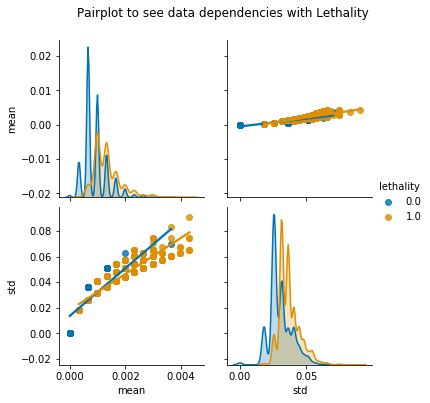

In [15]:
pair=sns.pairplot(corr_keys,hue='lethality',diag_kind='kde',kind='reg',palette='colorblind')
pair.fig.suptitle('Pairplot to see data dependencies with Lethality',y=1.08)

### Pearson correlation

In [16]:
a=scipy.stats.pearsonr(corr_keys['mean'],corr_keys['lethality'])
p_value_corr=defaultdict(dict)

columns=['mean','std']
for i in columns:
    
    tmp=scipy.stats.pearsonr(corr_keys[i],corr_keys['lethality'])
    p_value_corr[i]['corr with lethality']=tmp[0]
    p_value_corr[i]['p-value']=tmp[1]

p_value_corr_pd=pd.DataFrame(p_value_corr)
p_value_corr_pd

,mean,std
corr with lethality,0.426448,3.782763e-01
p-value,0.000000,3.912685e-253


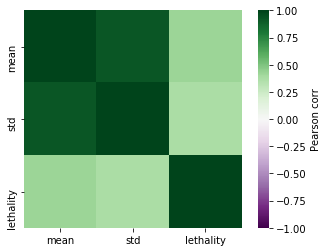

In [17]:
corr = corr_keys.corr()
sns.heatmap(corr, vmax=1,vmin=-1 ,square=True,cmap=cm.PRGn,cbar_kws={'label':'Pearson corr'})

## Learning algorithm

In [18]:
X, y = feature_post.drop(columns=["lethality"]), feature_post["lethality"]

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.3, random_state= 0)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (5236, 3025) (5236,)
Test set: (2245, 3025) (2245,)


### Choosing the best SVM model

- `from sklearn.model_selection import GridSearchCV`
- `from sklearn.svm import SVC`
- `parameters = [{'C': [1, 10, 100], 'kernel': ['rbf'], 'gamma': ['auto','scale']}]`
- `search = GridSearchCV(SVC(), parameters, n_jobs=-1, verbose=1)`
- `search.fit(X_train, y_train)`

Then,
- `best_parameters = search.best_estimator_`
- `print(best_parameters)`

I got in this case the following model, to fit the training data:

In [20]:
from sklearn import svm

clf = svm.SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8

### Making predictions

In [21]:
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import jaccard_score

y_pred = clf.predict(X_test)

print('The mean squared error is =',metrics.mean_squared_error(y_test,y_pred))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('The Jaccard index is =', jaccard_score(y_test, y_pred))
print('The log-loss is =',log_loss(y_test,y_pred))

print('The f1-score is =',metrics.f1_score(y_test,y_pred))


The mean squared error is = 0.2
Test set Accuracy:  0.8
The Jaccard index is = 0.6656738644825019
The log-loss is = 6.907832923632374
The f1-score is = 0.7992847563701384


- Jaccard similarity coefficient, defined as the size of the intersection divided by the size of the union of two label sets. The closer to 1 the better the classifier 
- Log loss is how far each prediction is from the actual label, it is like a distance measure from the predicted to the actual , the classifier with lower log loss have better accuracy
- F1-score:  can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['NonSl','SL']))

              precision    recall  f1-score   support

       NonSl       0.80      0.81      0.80      1120
          SL       0.80      0.79      0.80      1125

    accuracy                           0.80      2245
   macro avg       0.80      0.80      0.80      2245
weighted avg       0.80      0.80      0.80      2245



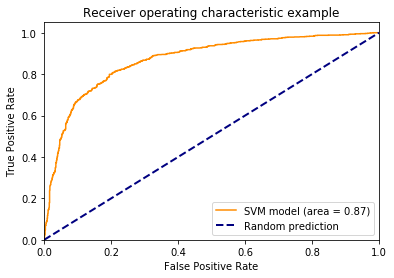

In [23]:
import sklearn.metrics as metrics
scores=clf.decision_function(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)
area=metrics.auc(fpr,tpr)
plt.plot(fpr,tpr,color='darkorange',label='SVM model (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random prediction')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

Text(0.5, 257.44, 'Predicted label')

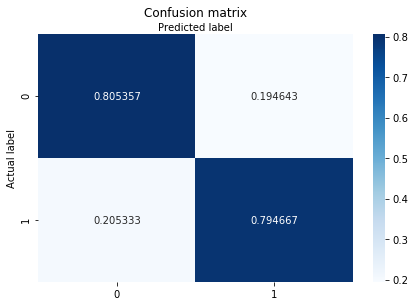

In [24]:
class_names=[1,2,3]
fig, ax = plt.subplots()
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

cm = confusion_matrix(y_test, y_pred,normalize="true")

class_names=['SL', 'nSL']

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

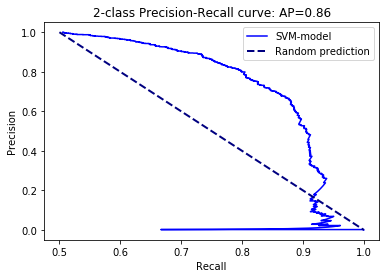

In [25]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, scores)
average_precision = metrics.average_precision_score(y_test, scores)
plt.plot(precision,recall,color='blue',label='SVM-model')

plt.plot([0.5, 1], [1, 0], color='navy', lw=2, linestyle='--',label='Random prediction')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.legend()